❓ **How could Olist improve its profit** ❓

## Getting our data 

In [1]:
#importing all the main modules
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from olist.seller import Seller
from olist.order import Order
from olist.data import Olist

In [2]:
#getting the training data
training_data = Seller().get_training_data()

In [3]:
#getting the main datasets
data = Olist().get_data()
#generating datasets to be merged
order_reviews = data['order_reviews']
order_items = data['order_items']
orders = data['orders']

### Dropping the non-delivered orders from our analysis due its immateriality

In [4]:
#checking the materiality of taking the non-delivered orders out of scope of our analysis
non_del_mat = abs(round((orders[orders['order_status']=='delivered'].shape[0] - orders.shape[0])/orders.shape[0]*100,2))

print(f'The materiality of non-delivered orders is at {non_del_mat}%')


The materiality of non-delivered orders is at 2.98%


In [5]:
#filtering the orders dataset to only have delivered orders
orders_delivered = orders[orders['order_status']=='delivered']

### Data Merge and Analysis

### Merge of the orders and order_items tables

In [6]:
#merging the tables together
review_items = order_reviews.merge(order_items, on="order_id")\
                        .merge(orders_delivered,on='order_id')

#placing seller_id in the first column
seller_id = review_items.pop('seller_id')
review_items.insert(0,'seller_id',seller_id)

### Calculating the costs of reviews

In [7]:
#cost of bad reviews
review_costs = {1 : 100,
                2 : 50,
                3 : 40,
                4 : 0,
                5 : 0}

#multiplying the cost per review to get the costs for each seller
review_items['cost_of_reviews'] = review_items['review_score']\
                                .map(review_costs)*review_items['review_score']

cost_of_reviews = review_items.pop('cost_of_reviews')
review_items.insert(4,'cost_of_reviews',cost_of_reviews)

### Aggregation of costs of reviews for each seller and merging with the Seller Training Data

In [8]:
#aggregating the costs of review for each seller
seller_review_costs_temp = review_items.groupby('seller_id')\
                                       ['cost_of_reviews'].sum()\
                                      .reset_index()

In [23]:
#Merging the training data dataset with the seller dataset
sellers_master = training_data\
    .merge(seller_review_costs_temp,on='seller_id')

In [25]:
#Define the revenue per seller per sale, revenue seller platform subscription
#and total revenue from the sellers

sellers_master['seller_sales_revenue'] = sellers_master['sales'] * 0.1
sellers_master['seller_subscription_revenue'] = sellers_master['months_on_olist'] * 80
sellers_master['seller_total_revenue'] = sellers_master['seller_sales_revenue'] + sellers_master['seller_subscription_revenue']

sellers_master['sellers_profits'] = sellers_master['seller_total_revenue'] - sellers_master['cost_of_reviews']

### Organizing the merged dataset for user convenience

In [26]:
#sort the sellers by the ascending profitability
sellers_master_sorted = sellers_master\
    .sort_values('sellers_profits',ascending=True)

In [12]:
columns_order_old = sellers_master_sorted.columns
columns_order_new = ['seller_id',\
                    'sellers_profits',\
                    'seller_total_revenue',\
                    'seller_sales_revenue',\
                    'seller_subscription_revenue',\
                    'cost_of_reviews',\
                    'sales',\
                    'review_score',\
                    'seller_city',\
                    'seller_state',\
                    'share_of_five_stars',\
                    'share_of_one_stars',\
                    'quantity',\
                    'quantity_per_order',\
                    'delay_to_carrier',\
                    'wait_time',\
                    'date_first_sale',\
                    'date_last_sale',\
                    'months_on_olist',\
                    'n_orders']


In [13]:
#re-order the table for the convenience of use
sellers_master_sor_ord = sellers_master_sorted[columns_order_new].reset_index()

sellers_master_sor_ord = sellers_master_sor_ord.drop('index',axis=1)

### Sellers analysis

Text(0.5, 1.0, 'Sellers Profits Distribution')

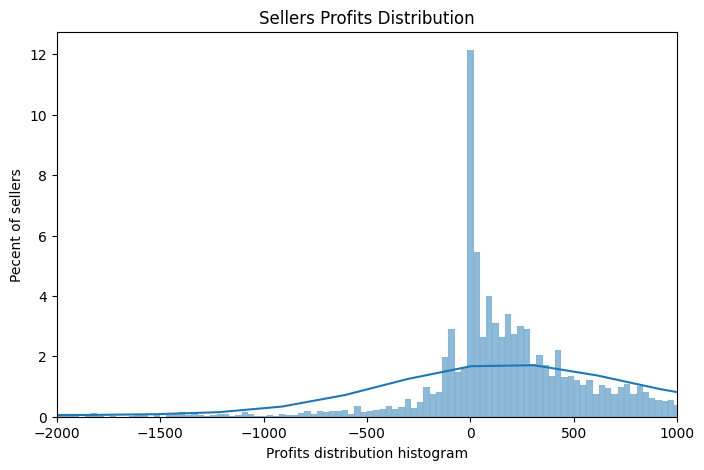

In [14]:
plt.figure(figsize=(8,5))
sns.histplot(sellers_master_sor_ord['sellers_profits'],stat='percent',bins=2000,kde=True)
plt.xlim(-2000,1000)
plt.xlabel('Profits distribution histogram')
plt.ylabel('Pecent of sellers')
plt.title('Sellers Profits Distribution')

#### Seller distribution by profits

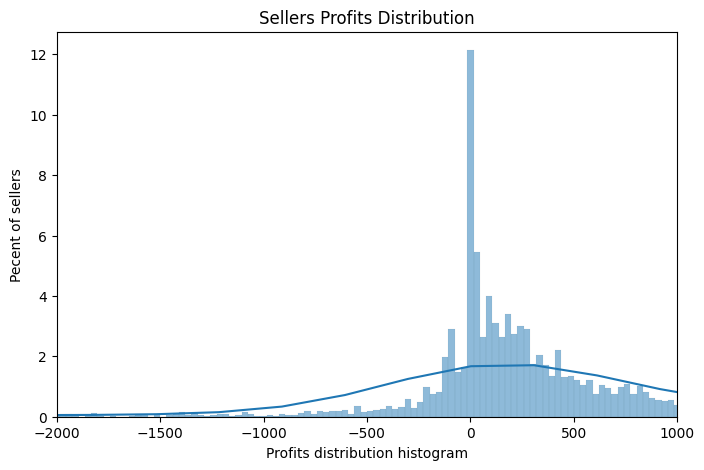

#### A quarter of our sellers are loss-making for the company

In [15]:
percent_loss_sellers = (sellers_master_sorted[sellers_master_sorted['sellers_profits']<0].count())\
    / sellers_master_sorted['sellers_profits'].shape[0]

f"Loss-making Sellers comprise {round(percent_loss_sellers[0]*100,1)}% \
of the total Sellers on Olist platform"

'Loss-making Sellers comprise 23.4% of the total Sellers on Olist platform'

In [16]:
#select profitable and non-profitable
non_prof_sellers = sellers_master_sor_ord[sellers_master_sor_ord['sellers_profits']<0]
prof_sellers = sellers_master_sor_ord[sellers_master_sor_ord['sellers_profits']>0]

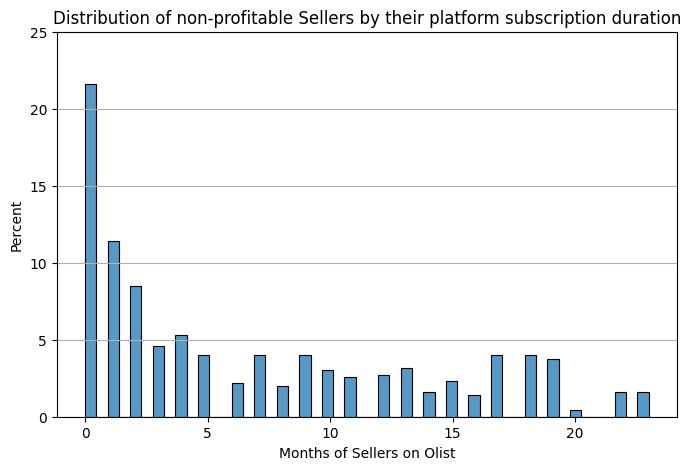

In [17]:
#check of the distribution of review scores for the
plt.figure(figsize=(8,5))
sns.histplot(non_prof_sellers['months_on_olist'],bins=50,stat='percent')
plt.ylim(0,25)
plt.ylim(0,25)
plt.title('Distribution of non-profitable Sellers\
 by their platform subscription duration')
plt.xlabel('Months of Sellers on Olist')

plt.grid(True,axis='y')

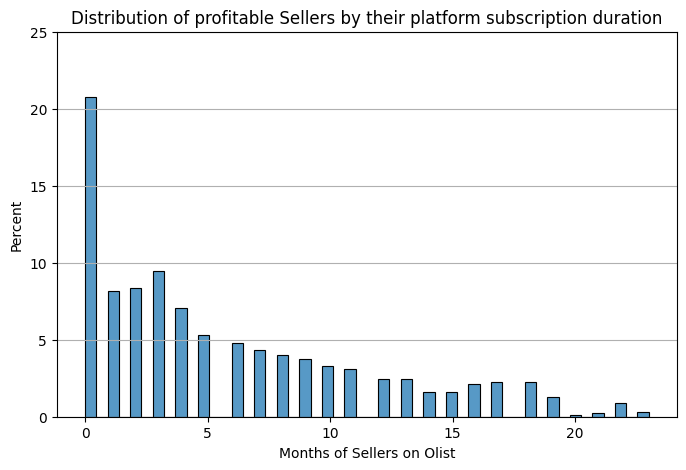

In [18]:
plt.figure(figsize=(8,5))

sns.histplot(prof_sellers['months_on_olist'],bins=50,stat='percent')
plt.ylim(0,25)
plt.title('Distribution of profitable Sellers\
 by their platform subscription duration')
plt.xlabel('Months of Sellers on Olist')

plt.grid(True,axis='y')

### Non-profitable vs Profitable sellers in regards to wait_time

#### Non-profitable Sellers

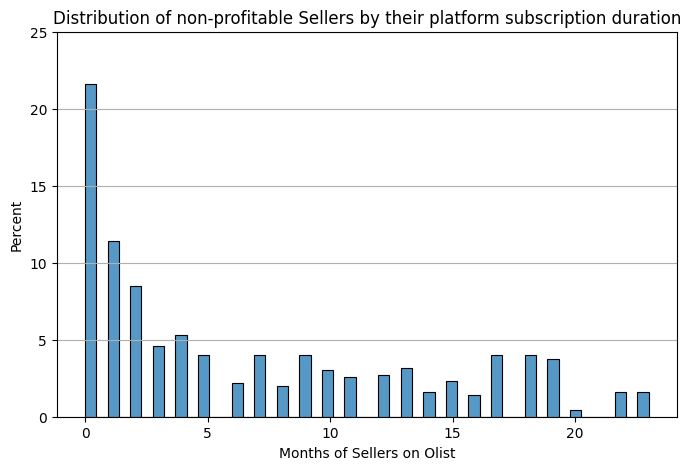 !

#### Profitable Sellers

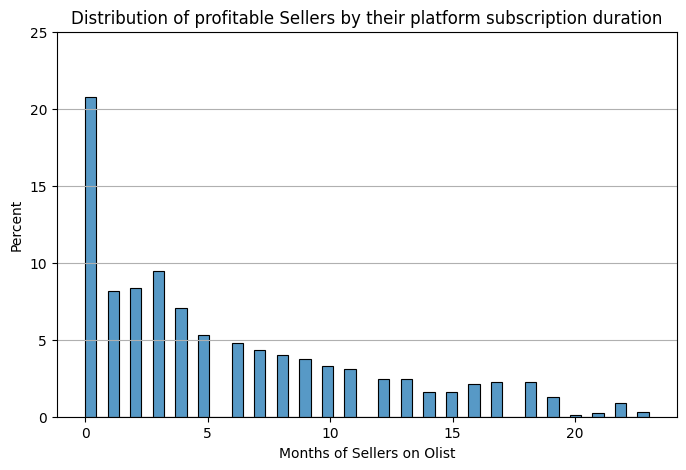

### Wait Time for Profitable and Non-profitable Sellers

Text(0, 0.5, 'Distribution Percentage')

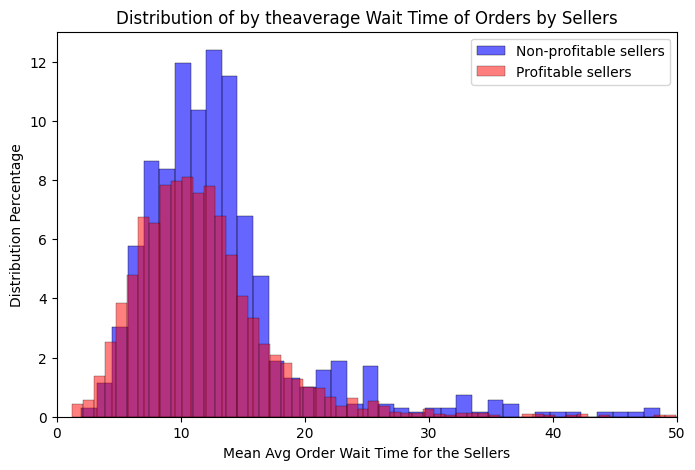

In [19]:
#check of the distribution of review scores for the
plt.figure(figsize=(8,5))

plot1 = sns.histplot(non_prof_sellers['wait_time'],stat='percent',color='blue',alpha=0.6,label='Non-profitable sellers')
plot2 = sns.histplot(prof_sellers['wait_time'],stat='percent',color='red',alpha=0.5,label='Profitable sellers')
plt.xlim(0,50)

plt.legend()
plt.title('Distribution of by theaverage Wait Time of Orders by Sellers')
plt.xlabel('Mean Avg Order Wait Time for the Sellers')
plt.ylabel('Distribution Percentage')

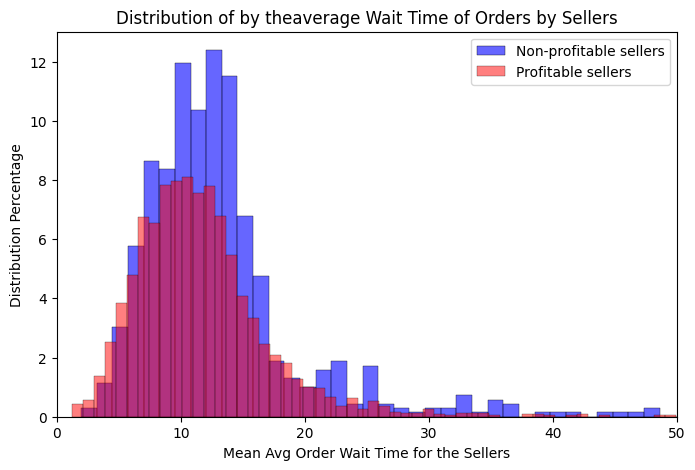

## Profit Optimization with existing Customer Base

In [27]:
alpha = 3157.27
beta = 978.23

ops_profits_list = []
ops_profit_margin = []
sellers_iterative = sellers_master_sor_ord.copy()

for i in range(sellers_iterative.shape[0]):
    it_costs =  alpha * sellers_master_sor_ord.shape[0]**(1/2)\
            + beta * sellers_master_sor_ord['quantity'].sum()**(1/2)

    profit = sellers_iterative['sellers_profits'].sum() - it_costs
    profit_margin = 100*(profit /\
        (sellers_iterative['seller_total_revenue'].sum()))

    ops_profits_list.append(profit)
    ops_profit_margin.append(profit_margin)

    sellers_iterative = sellers_iterative.iloc[1:]\
        .reset_index(drop=True)

In [21]:
max_profit = max(ops_profits_list)
max_profit_rounded = round(max_profit,2)

opt_removal = ops_profits_list.index(max_profit)

print(f'Given all factors remain constant, removing {opt_removal} worst performing Sellers measured by profitability\
    would allow to achieve the profit level in the amount of BRL {max_profit_rounded}')

Given all factors remain constant, removing 694 worst performing Sellers measured by profitability    would allow to achieve the profit level in the amount of BRL 591555.39


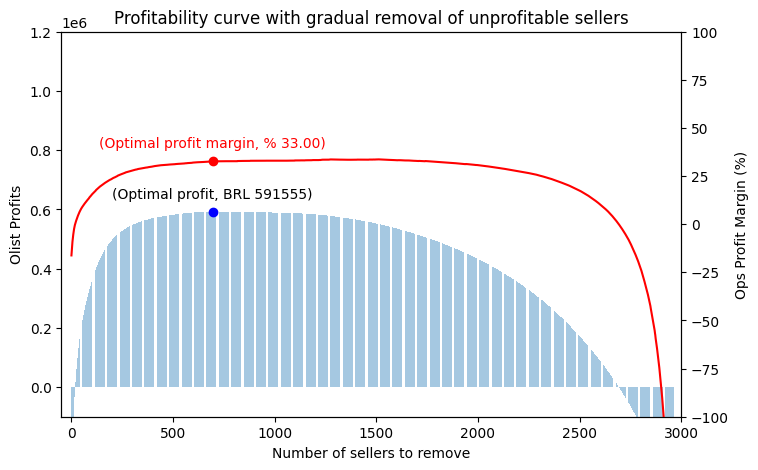

In [22]:
# Correcting the plot code and adding grid and coordinate annotations
fig, ax1 = plt.subplots(figsize=(8,5))

# Plotting ops_profits_list as a bar plot
ax1.bar(range(len(ops_profits_list)), ops_profits_list, alpha=0.4)
ax1.set_xlabel('Number of sellers to remove')
ax1.set_ylabel('Olist Profits')
ax1.set_xlim(-50, 3000)
ax1.set_ylim(-100000, 1200000)

# Highlighting the specific point with opt_removal
ax1.plot(opt_removal, ops_profits_list[opt_removal], 'bo')  # Blue dot on bar plot
ax1.annotate(f'(Optimal profit, BRL {round(ops_profits_list[opt_removal])})',
             (opt_removal, ops_profits_list[opt_removal]),
             textcoords="offset points", xytext=(0,10), ha='center')

# Creating a second y-axis for ops_profit_margin as a line plot
ax2 = ax1.twinx()
ax2.plot(range(len(ops_profit_margin)), ops_profit_margin, color='red')
ax2.set_ylabel('Ops Profit Margin (%)')
ax2.set_ylim(-100, 100)

# Highlighting the specific point with opt_removal on the second y-axis
ax2.plot(opt_removal, ops_profit_margin[opt_removal], 'ro')  # Red dot on line plot
ax2.annotate(f'(Optimal profit margin, % {round(ops_profit_margin[opt_removal],0):.2f})',
             (opt_removal, ops_profit_margin[opt_removal]),
             textcoords="offset points", xytext=(0,10), ha='center', color='red')

plt.title("Profitability curve with gradual removal of unprofitable sellers")
#plt.grid(True)
plt.show()

### Elevating profitability through improving unit economics

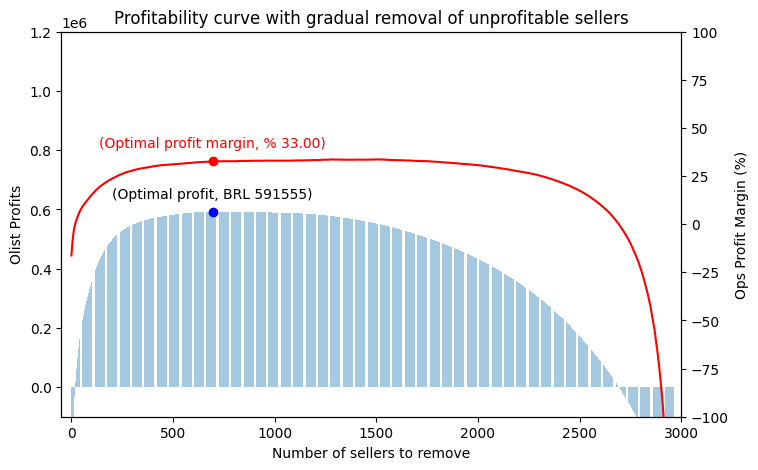

## Possible Solutions

### Cost reduction steps

1. Reduce the Number of Sellers
   - Action: Cut unprofitable sellers by 694.
   - Benefit: Immediate profitability boost.
   - Downside: Loss of economies of scale and network effects.

2. Adjust Subscription Fees
   - Non-Tiered:
     - Action: Flat increase in platform usage fees.
     - Benefit: Immediate profitability.
     - Downside: May deter high-profit sellers.
   - Tiered:
     - Action: Higher fees for non-profitable sellers until they reach profitability.
     - Benefit: Gradual profitability increase.


### Alternative

3. Analyze Loss-Making Factors

   - Action: Investigate causes of negative reviews and low sales.

   - Benefit: Gain insights into underperformance.
   
   - Downside: Prolonged presence of loss-making sellers may harm profit margins.